In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.models as models

from PIL import Image
import io, pickle
from tqdm import tqdm, trange
import numpy as np
import random

In [9]:
with open('images/images.pickle', 'rb') as f:
    img_data = pickle.load(f)
class CustomDataset(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(label))
        return img, label

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_train = CustomDataset(img_data=img_data, txt_file='images/train.txt', transform=transform_train)
dataset_val = CustomDataset(img_data=img_data, txt_file='images/val.txt', transform=transform)
dataset_test = CustomDataset(img_data=img_data, txt_file='images/test.txt', transform=transform)


data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=16)
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=16)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=16)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
for lr in [1e-5]:
    model = models.resnet34(pretrained=False)
    num_classes = 50
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.00025)
    num_epochs = 10
    save_path = 'record/Q2_baseline'
    rec_name = 'adamW_0.00025_augmentless'
    model_path = f'{save_path}/model_weight/model_weight_lr{lr}_{rec_name}.pth'
    best_val_loss = float('inf')
    best_model = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(data_loader_train, colour='green', total=len(data_loader_train))
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Train Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
        running_loss_avg = running_loss / len(dataset_train)
        running_acc_avg = running_acc / len(dataset_train)
        train_loss.append(running_loss_avg)
        train_acc.append(running_acc_avg)
        print(f"Epoch {epoch+1}, Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")

        model.eval()
        with torch.no_grad():
            class_counts = [0] * 50
            running_loss = 0.0
            running_acc = 0.0
            pbar = tqdm(data_loader_val, colour='red', total=len(data_loader_val))
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predictions = outputs.argmax(dim=1)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*len(labels)
                running_acc += (predictions == labels).float().sum().item()
                pbar.set_description(f'Valid Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
                pbar.update()

                for pred_label in predictions:
                    class_counts[pred_label] += 1

            running_loss_avg = running_loss / len(dataset_val)
            running_acc_avg = running_acc / len(dataset_val)
            val_loss.append(running_loss_avg)
            val_acc.append(running_acc_avg)
            print(f"Validation Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")
            print(f"Class Counts: {class_counts}")
            if running_loss_avg < best_val_loss:
                best_val_loss = running_loss
                best_model = model
                torch.save(model.state_dict(), model_path)
        print("======================================")
    print("Finished Training")


    model.eval()
    with torch.no_grad():
        class_counts = [0] * 50
        running_loss = 0.0
        running_acc = 0.0
        predictions = []
        true_labels = []
        pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
 
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)
 
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
 
        for pred_label in predictions:
            class_counts[pred_label] += 1

        precision = precision_score(true_labels, predictions, average='weighted')
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print(f"Class Counts: {class_counts}")
    print("Finished Testing")

    train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    test_record = {"true_labels": true_labels, "predictions": predictions, "precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}


    with open(f'{save_path}/train_record/train_record_lr{lr}_{rec_name}.pkl', 'wb') as f:
        pickle.dump(train_record, f)
    with open(f'{save_path}/test_record/test_record_lr{lr}_{rec_name}.pkl', 'wb') as f:
        pickle.dump(test_record, f)


/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Train Iter: 001/010  Loss: 2.9769: 100%|██████████| 1979/1979 [00:59<00:00, 33.49it/s]


Epoch 1, Loss: 3.4601445040569163, Accuracy: 0.1111251480457955


Valid Iter: 001/010  Loss: 1.7527: 100%|██████████| 15/15 [00:01<00:00, 13.52it/s]


Validation Loss: 3.0735281896591187, Accuracy: 0.16666666666666666
Class Counts: [16, 8, 2, 7, 41, 5, 3, 1, 5, 3, 1, 0, 0, 3, 8, 5, 2, 1, 1, 13, 16, 6, 3, 17, 4, 5, 0, 14, 5, 6, 3, 2, 10, 34, 16, 5, 6, 17, 17, 40, 12, 8, 3, 1, 3, 9, 9, 6, 15, 33]


Train Iter: 002/010  Loss: 2.9675: 100%|██████████| 1979/1979 [00:58<00:00, 33.58it/s]


Epoch 2, Loss: 2.9980289685504973, Accuracy: 0.1936991709435452


Valid Iter: 002/010  Loss: 1.5497: 100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


Validation Loss: 2.797937249077691, Accuracy: 0.22444444444444445
Class Counts: [7, 4, 14, 7, 21, 11, 4, 12, 7, 1, 2, 0, 1, 11, 23, 15, 18, 5, 5, 9, 8, 10, 5, 5, 6, 8, 10, 11, 5, 1, 5, 0, 13, 14, 9, 16, 12, 7, 21, 11, 9, 15, 4, 5, 14, 11, 8, 5, 15, 10]


Train Iter: 003/010  Loss: 2.5659: 100%|██████████| 1979/1979 [00:58<00:00, 33.60it/s]


Epoch 3, Loss: 2.773920254716749, Accuracy: 0.23936833793920254


Valid Iter: 003/010  Loss: 1.3299: 100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Validation Loss: 2.6429608080122207, Accuracy: 0.24222222222222223
Class Counts: [11, 6, 17, 12, 24, 10, 2, 9, 5, 1, 6, 0, 5, 5, 11, 22, 2, 2, 8, 19, 7, 7, 8, 11, 10, 6, 7, 13, 7, 5, 2, 4, 15, 16, 3, 14, 5, 8, 11, 20, 7, 10, 14, 11, 12, 4, 10, 4, 16, 6]


Train Iter: 004/010  Loss: 2.2748: 100%|██████████| 1979/1979 [00:58<00:00, 33.62it/s]


Epoch 4, Loss: 2.6183956286335857, Accuracy: 0.2747729964469009


Valid Iter: 004/010  Loss: 0.7414: 100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


Validation Loss: 2.5917150860362583, Accuracy: 0.2733333333333333
Class Counts: [9, 7, 10, 11, 24, 10, 5, 7, 6, 2, 12, 1, 8, 17, 10, 15, 5, 4, 7, 17, 14, 8, 9, 6, 7, 11, 1, 8, 3, 2, 1, 8, 1, 10, 11, 15, 8, 9, 17, 10, 18, 11, 3, 29, 7, 6, 3, 1, 16, 10]


Train Iter: 005/010  Loss: 2.1254: 100%|██████████| 1979/1979 [00:59<00:00, 33.45it/s]


Epoch 5, Loss: 2.4840408367175053, Accuracy: 0.3057244374259771


Valid Iter: 005/010  Loss: 0.9119: 100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


Validation Loss: 2.3855743228064643, Accuracy: 0.33555555555555555
Class Counts: [21, 10, 7, 9, 26, 19, 4, 9, 9, 1, 5, 1, 6, 11, 12, 4, 1, 9, 2, 13, 13, 3, 13, 8, 5, 9, 5, 20, 6, 5, 6, 7, 5, 12, 13, 12, 8, 10, 18, 6, 10, 8, 7, 15, 6, 8, 9, 4, 13, 7]


Train Iter: 006/010  Loss: 2.4417: 100%|██████████| 1979/1979 [00:58<00:00, 33.58it/s]


Epoch 6, Loss: 2.3631048045890677, Accuracy: 0.33317015396762734


Valid Iter: 006/010  Loss: 1.2369: 100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


Validation Loss: 2.2783249107996624, Accuracy: 0.3333333333333333
Class Counts: [13, 6, 16, 11, 21, 14, 12, 19, 8, 3, 3, 1, 6, 6, 7, 7, 2, 9, 7, 9, 9, 3, 11, 7, 7, 8, 7, 8, 10, 7, 9, 9, 8, 4, 7, 15, 9, 9, 13, 11, 15, 8, 6, 17, 7, 8, 9, 7, 17, 5]


Train Iter: 007/010  Loss: 2.1780: 100%|██████████| 1979/1979 [00:59<00:00, 33.48it/s]


Epoch 7, Loss: 2.262865359008524, Accuracy: 0.35804184761152785


Valid Iter: 007/010  Loss: 0.7545: 100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


Validation Loss: 2.16221415731642, Accuracy: 0.3488888888888889
Class Counts: [11, 5, 10, 8, 20, 9, 9, 8, 11, 2, 3, 3, 7, 14, 9, 12, 3, 9, 10, 15, 13, 2, 11, 6, 6, 12, 2, 13, 5, 5, 8, 9, 6, 11, 12, 7, 10, 10, 13, 14, 12, 6, 9, 17, 14, 7, 8, 4, 15, 5]


Train Iter: 008/010  Loss: 1.8072: 100%|██████████| 1979/1979 [00:59<00:00, 33.52it/s]


Epoch 8, Loss: 2.16557292580934, Accuracy: 0.3803237268061587


Valid Iter: 008/010  Loss: 0.3943: 100%|██████████| 15/15 [00:01<00:00, 13.95it/s]


Validation Loss: 2.0771965045399137, Accuracy: 0.3977777777777778
Class Counts: [12, 11, 4, 9, 13, 7, 11, 7, 8, 5, 10, 4, 8, 19, 10, 8, 2, 6, 8, 11, 7, 6, 8, 9, 6, 13, 9, 11, 2, 6, 5, 10, 12, 9, 6, 9, 8, 12, 16, 12, 13, 7, 9, 17, 9, 7, 12, 4, 15, 8]


Train Iter: 009/010  Loss: 1.8676: 100%|██████████| 1979/1979 [00:59<00:00, 33.45it/s]


Epoch 9, Loss: 2.0847284994057595, Accuracy: 0.4026529806553494


Valid Iter: 009/010  Loss: 0.4314: 100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


Validation Loss: 2.03288434876336, Accuracy: 0.4022222222222222
Class Counts: [8, 7, 20, 13, 8, 7, 8, 20, 10, 15, 12, 4, 7, 11, 10, 5, 4, 6, 15, 4, 4, 6, 8, 7, 16, 19, 2, 4, 9, 2, 4, 8, 8, 5, 6, 8, 6, 10, 12, 8, 9, 9, 11, 17, 10, 13, 10, 6, 11, 8]


Train Iter: 010/010  Loss: 1.9257: 100%|██████████| 1979/1979 [00:59<00:00, 33.49it/s]


Epoch 10, Loss: 2.0021228084590565, Accuracy: 0.42119226213975525


Valid Iter: 010/010  Loss: 0.1448: 100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


Validation Loss: 1.9722185044818454, Accuracy: 0.41333333333333333
Class Counts: [9, 3, 12, 5, 9, 7, 8, 7, 9, 6, 9, 2, 6, 7, 27, 6, 8, 12, 17, 18, 3, 12, 12, 6, 8, 5, 1, 6, 4, 5, 5, 11, 8, 7, 8, 14, 10, 10, 13, 14, 9, 9, 8, 12, 13, 14, 9, 8, 11, 8]
Finished Training


Test Iter: 010/010  Loss: 0.7680: 100%|██████████| 15/15 [00:01<00:00, 13.54it/s]


Test Loss: 2.0011892032623293, Accuracy: 0.42
Precision: 0.43992243738373765, Recall: 0.42, F1: 0.41111491785162524
Class Counts: [10, 6, 8, 7, 7, 6, 8, 13, 6, 2, 8, 3, 9, 4, 19, 9, 12, 9, 9, 14, 8, 10, 12, 8, 10, 6, 5, 8, 4, 4, 14, 9, 4, 12, 9, 12, 5, 10, 9, 10, 17, 9, 8, 10, 15, 18, 10, 6, 8, 11]
Finished Testing


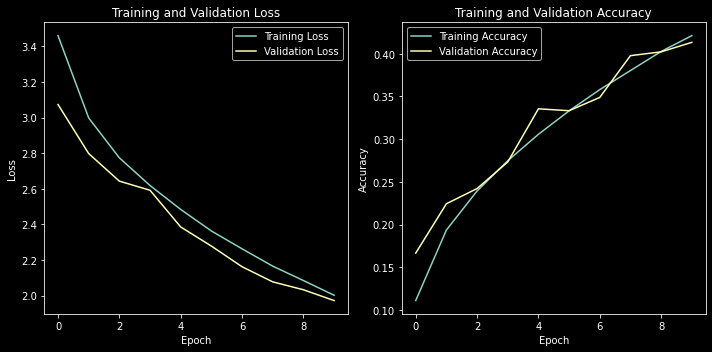

[0.1111251480457955, 0.1936991709435452, 0.23936833793920254, 0.2747729964469009, 0.3057244374259771, 0.33317015396762734, 0.35804184761152785, 0.3803237268061587, 0.4026529806553494, 0.42119226213975525]
[0.16666666666666666, 0.22444444444444445, 0.24222222222222223, 0.2733333333333333, 0.33555555555555555, 0.3333333333333333, 0.3488888888888889, 0.3977777777777778, 0.4022222222222222, 0.41333333333333333]


(0.43992243738373765, 0.42, 0.41111491785162524)

In [1]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_baseline/train_record/train_record_lr1e-05_adamW_0.00025_augmentless.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_baseline/test_record/test_record_lr1e-05_adamW_0.00025_augmentless.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'])
print(train_record['val_acc'])
test_record['precision'], test_record['recall'], test_record['f1']